# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


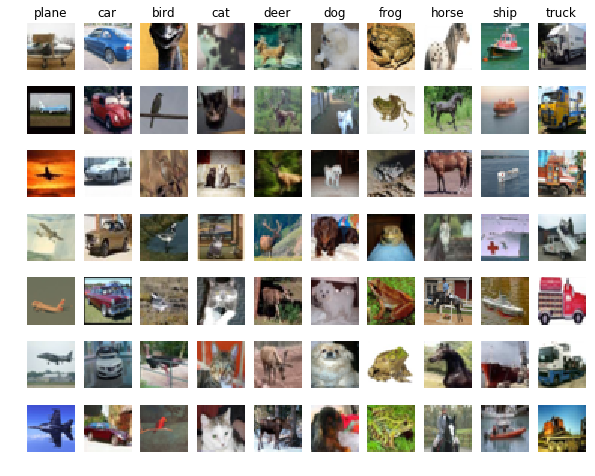

In [2]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [36]:
# Use the validation set to tune the learning rate and regularization strength. You can 
# reuse the softmax_hyperparameter_tuning that you implemented in
# exercise_code.classifiers.softmax

from exercise_code.classifiers.softmax_f import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax = None

################################################################################
# TODO: Train a softmax classifier on the features and tune hyperparameters to #
# obtain a strong model. You can alter and reuse the                           #
# softmax_hyperparameter_tuning function. Store your best network in the       #
# best_softmax variable.                                                       #
################################################################################
def softmax_hyperparameter_tuning_new(X_train, y_train, X_val, y_val):    
    results = {}
    best_val = -1
    best_softmax = None
    all_classifiers = []
    #learning_rates = [1e-7, 5e-7]
    learning_rates = [1e-7]#, 5e-7, 8e-7]
    regularization_strengths = [0.0]#, 0.1, 0.2]
    niter= [10000, 100]
    
    best_key = -1
    ############################################################################
    # TODO:                                                                    #
    # Write code that chooses the best hyperparameters by tuning on the        #
    # validation set. For each combination of hyperparameters, train a         #
    # classifier on the training set, compute its accuracy on the training and #
    # validation sets, and  store these numbers in the results dictionary.     #
    # In addition, store the best validation accuracy in best_val and the      #
    # Softmax object that achieves this accuracy in best_softmax.              #                                      #
    #                                                                          #
    # Hint: You should use a small value for num_iters as you develop your     #
    # validation code so that the classifiers don't take much time to train;   # 
    # once you are confident that your validation code works, you should rerun #
    # the validation code with a larger value for num_iters.                   #
    ############################################################################
    ##for lrate in xrange(learning_rates[0], learning_rates[1] + mystep, mystep):
      ##   for rstrength in xrange(regularization_strengths[0], regularization_strengths[1] + step, step)
    
    for lr in learning_rates:
        for rs in regularization_strengths:
            for ni in niter:
                print(lr, rs, ni)
                softmax = SoftmaxClassifier()
                softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=ni, verbose = True)
                #print(loss)
                y_train_pred = softmax.predict(X_train)
                y_val_pred = softmax.predict(X_val)
                t_a = np.mean(y_train == y_train_pred)
                v_a = np.mean(y_val == y_val_pred)
                results[(lr,rs)]  = t_a, v_a
                print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                  lr, rs, t_a, v_a))

                best_val = max(best_val, v_a)
                if(best_val== v_a):
                    best_key = (lr,rs)
                    best_softmax = softmax
                all_classifiers.append(softmax)

        
    print('best validation accuracy achieved during validation: %f' % best_val)
    print('best key: ', best_key)

    return best_softmax #, results, all_classifiers


best_softmax = softmax_hyperparameter_tuning_new(X_train_feats, y_train, X_val_feats, y_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

KeyboardInterrupt: 

n_iter= 3000

lr 1.000000e-07 reg 0.000000e+00 train accuracy: 0.189229 val accuracy: 0.186000
lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.172417 val accuracy: 0.162000
lr 1.000000e-07 reg 2.000000e-01 train accuracy: 0.208625 val accuracy: 0.216000
lr 5.000000e-07 reg 0.000000e+00 train accuracy: 0.354896 val accuracy: 0.333000
lr 5.000000e-07 reg 1.000000e-01 train accuracy: 0.353417 val accuracy: 0.353000
lr 5.000000e-07 reg 2.000000e-01 train accuracy: 0.356854 val accuracy: 0.348000
lr 8.000000e-07 reg 0.000000e+00 train accuracy: 0.381792 val accuracy: 0.366000
lr 8.000000e-07 reg 1.000000e-01 train accuracy: 0.380396 val accuracy: 0.382000
lr 8.000000e-07 reg 2.000000e-01 train accuracy: 0.386604 val accuracy: 0.400000
best validation accuracy achieved during validation: 0.400000
best key:  (8e-07, 0.2)


In [14]:
# Evaluate your trained classifier on the test set
best_softmax = best_softmax[0]

y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.374


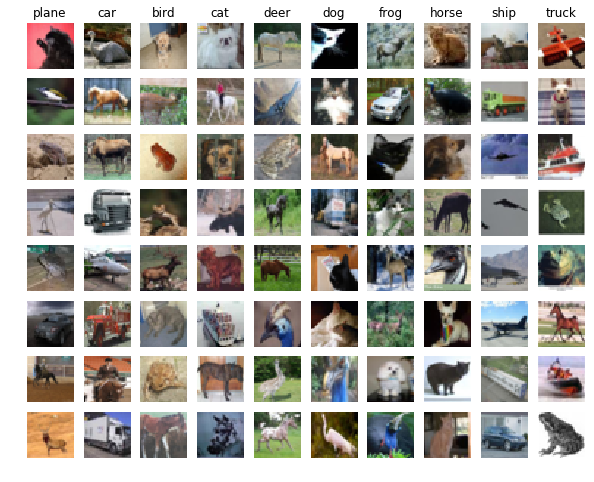

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
    <p>It is pictures that don't have a lot of colors: maximum 2 colors dominate in the picture.</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [17]:
print(X_train_feats.shape, y_train.shape, X_val_feats.shape, y_val.shape )

(48000, 155) (48000,) (1000, 155) (1000,)


In [33]:
from exercise_code.classifiers.neural_net_f import TwoLayerNet, neuralnetwork_hyperparameter_tuning

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best         #
# model in the best_net variable.                                              #
################################################################################
def neuralnetwork_hyperparameter_tuning_new(X_train, y_train, X_val, y_val):
    best_net = None # store the best model into this 
    ############################################################################
    # TODO: Tune hyperparameters using the validation set. Store your best     #
    # trained model in best_net.                                               #
    #                                                                          #
    # To help debug your network, it may help to use visualizations similar to #
    # the  ones we used above; these visualizations will have significant      #
    # qualitative differences from the ones we saw above for the poorly tuned  #
    # network.                                                                 #
    #                                                                          #
    # Tweaking hyperparameters by hand can be fun, but you might find it useful#
    # to  write code to sweep through possible combinations of hyperparameters #
    # automatically like we did on the previous exercises.                     #
    ############################################################################

    results = {}
    best_val = -1
    best_softmax = None
    all_classifiers = []
    
    
    #learning_rates = [0.0001] #for ex1.2
    #regularization_strengths = [0.1]
    #iterations = [15000, 100]
    #hs = [300]
    
    # 5e-5, decay = 0.99, iter = 20000, units 500, reg = 0.1
    learning_rates = [1e-4]#[1.5e-4,2e-4]#[8e-5, 8.5e-5, 9e-5]#[1e-5,5e-5,8e-5] # for ex 1.3
    regularization_strengths = [0.0]#[0.0, 0.1, 0.5]
    iterations = [20000,100]#, 100]
    hs = [500]
    
    input_size = X_train.shape[1]
    num_classes = 10
    
    for rs in regularization_strengths:    
        for lr in learning_rates:        
            for it in iterations:
                for h in  hs:
                        print(lr,rs,it,h)
            
            
                        net = TwoLayerNet(input_size, h, num_classes)


                        # Train the network
                        stats = net.train(X_train, y_train, X_val, y_val, num_iters=it, batch_size=200, learning_rate=lr, learning_rate_decay=0.99,reg=rs, verbose=True)

                        #print(loss)
                        y_train_pred = net.predict(X_train)
                        y_val_pred = net.predict(X_val)
                        t_a = np.mean(y_train == y_train_pred)
                        v_a = np.mean(y_val == y_val_pred)
                        results[(lr,rs,it,h)]  = t_a, v_a
                        print('lr %e reg %e it %e h %e train accuracy: %f val accuracy: %f' % (
              lr, rs, it, h, t_a, v_a))
                        
                        best_val = max(best_val, v_a)
                        if(best_val== v_a):
                            best_key = (lr,rs,it,h)
                            best_net = net
                            #yield best_net
                        all_classifiers.append(net)
            

        
    print('best validation accuracy achieved during validation: %f' % best_val)
    print('best key: ', best_key)

    return best_net

best_net = neuralnetwork_hyperparameter_tuning_new(X_train_feats, y_train, X_val_feats, y_val)


0.0001 0.0 20000 500
iteration 0 / 20000: loss 2.302585
iteration 100 / 20000: loss 2.046318
iteration 200 / 20000: loss 1.850104
iteration 300 / 20000: loss 1.794251
iteration 400 / 20000: loss 1.635227
iteration 500 / 20000: loss 1.500438
iteration 600 / 20000: loss 1.558537
iteration 700 / 20000: loss 1.533975
iteration 800 / 20000: loss 1.501371
iteration 900 / 20000: loss 1.428878
iteration 1000 / 20000: loss 1.388113
iteration 1100 / 20000: loss 1.334275
iteration 1200 / 20000: loss 1.372877
iteration 1300 / 20000: loss 1.359371
iteration 1400 / 20000: loss 1.230825
iteration 1500 / 20000: loss 1.305035
iteration 1600 / 20000: loss 1.261274
iteration 1700 / 20000: loss 1.287829
iteration 1800 / 20000: loss 1.433680
iteration 1900 / 20000: loss 1.417052
iteration 2000 / 20000: loss 1.436150
iteration 2100 / 20000: loss 1.304053
iteration 2200 / 20000: loss 1.521515
iteration 2300 / 20000: loss 1.223805
iteration 2400 / 20000: loss 1.336697
iteration 2500 / 20000: loss 1.480186
ite

0.0001 0.0 20000 500
iteration 0 / 20000: loss 2.302585
iteration 100 / 20000: loss 2.046318
iteration 200 / 20000: loss 1.850104
iteration 300 / 20000: loss 1.794251
iteration 400 / 20000: loss 1.635227
iteration 500 / 20000: loss 1.500438
iteration 600 / 20000: loss 1.558537
iteration 700 / 20000: loss 1.533975
iteration 800 / 20000: loss 1.501371
iteration 900 / 20000: loss 1.428878
iteration 1000 / 20000: loss 1.388113
iteration 1100 / 20000: loss 1.334275
iteration 1200 / 20000: loss 1.372877
iteration 1300 / 20000: loss 1.359371
iteration 1400 / 20000: loss 1.230825
iteration 1500 / 20000: loss 1.305035
iteration 1600 / 20000: loss 1.261274
iteration 1700 / 20000: loss 1.287829
iteration 1800 / 20000: loss 1.433680
iteration 1900 / 20000: loss 1.417052
iteration 2000 / 20000: loss 1.436150
iteration 2100 / 20000: loss 1.304053
iteration 2200 / 20000: loss 1.521515
iteration 2300 / 20000: loss 1.223805
iteration 2400 / 20000: loss 1.336697
iteration 2500 / 20000: loss 1.480186
iteration 2600 / 20000: loss 1.359916
iteration 2700 / 20000: loss 1.414217
iteration 2800 / 20000: loss 1.335561
iteration 2900 / 20000: loss 1.430642
iteration 3000 / 20000: loss 1.393823
iteration 3100 / 20000: loss 1.453392
iteration 3200 / 20000: loss 1.362253
iteration 3300 / 20000: loss 1.369744
iteration 3400 / 20000: loss 1.243268
iteration 3500 / 20000: loss 1.280419
iteration 3600 / 20000: loss 1.470815
iteration 3700 / 20000: loss 1.291173
iteration 3800 / 20000: loss 1.400452
iteration 3900 / 20000: loss 1.242317
iteration 4000 / 20000: loss 1.178477
iteration 4100 / 20000: loss 1.327124
iteration 4200 / 20000: loss 1.276808
iteration 4300 / 20000: loss 1.318122
iteration 4400 / 20000: loss 1.261894
iteration 4500 / 20000: loss 1.335461
iteration 4600 / 20000: loss 1.340993
iteration 4700 / 20000: loss 1.300646
iteration 4800 / 20000: loss 1.158976
iteration 4900 / 20000: loss 1.155465
iteration 5000 / 20000: loss 1.110573
iteration 5100 / 20000: loss 1.237422
iteration 5200 / 20000: loss 1.256787
iteration 5300 / 20000: loss 1.339877
iteration 5400 / 20000: loss 1.216219
iteration 5500 / 20000: loss 1.366024
iteration 5600 / 20000: loss 1.278487
iteration 5700 / 20000: loss 1.143828
iteration 5800 / 20000: loss 1.225269
iteration 5900 / 20000: loss 1.255959
iteration 6000 / 20000: loss 1.260852
iteration 6100 / 20000: loss 1.313948
iteration 6200 / 20000: loss 1.241320
iteration 6300 / 20000: loss 1.318209
iteration 6400 / 20000: loss 1.201822
iteration 6500 / 20000: loss 1.164471
iteration 6600 / 20000: loss 1.270818
iteration 6700 / 20000: loss 1.141744
iteration 6800 / 20000: loss 1.192274
iteration 6900 / 20000: loss 1.098422
iteration 7000 / 20000: loss 1.224031
iteration 7100 / 20000: loss 1.238149
iteration 7200 / 20000: loss 1.234879
iteration 7300 / 20000: loss 1.234917
iteration 7400 / 20000: loss 1.140152
iteration 7500 / 20000: loss 1.056557
iteration 7600 / 20000: loss 1.250839
iteration 7700 / 20000: loss 1.282563
iteration 7800 / 20000: loss 1.042721
iteration 7900 / 20000: loss 1.122146
iteration 8000 / 20000: loss 0.980457
iteration 8100 / 20000: loss 1.114159
iteration 8200 / 20000: loss 1.244544
iteration 8300 / 20000: loss 1.027962
iteration 8400 / 20000: loss 1.131322
iteration 8500 / 20000: loss 1.115565
iteration 8600 / 20000: loss 1.136272
iteration 8700 / 20000: loss 1.142663
iteration 8800 / 20000: loss 1.156891
iteration 8900 / 20000: loss 1.046933
iteration 9000 / 20000: loss 1.019340
iteration 9100 / 20000: loss 1.021353
iteration 9200 / 20000: loss 1.082971
iteration 9300 / 20000: loss 1.075485
iteration 9400 / 20000: loss 1.101690
iteration 9500 / 20000: loss 1.129636
iteration 9600 / 20000: loss 1.099367
iteration 9700 / 20000: loss 1.136881
iteration 9800 / 20000: loss 1.066237
iteration 9900 / 20000: loss 1.171539
iteration 10000 / 20000: loss 1.038184
iteration 10100 / 20000: loss 1.112204
iteration 10200 / 20000: loss 1.134229
iteration 10300 / 20000: loss 1.053143
iteration 10400 / 20000: loss 1.179520
iteration 10500 / 20000: loss 1.106885
iteration 10600 / 20000: loss 1.030333
iteration 10700 / 20000: loss 1.017788
iteration 10800 / 20000: loss 1.158168
iteration 10900 / 20000: loss 1.099454
iteration 11000 / 20000: loss 1.020428
iteration 11100 / 20000: loss 1.166276
iteration 11200 / 20000: loss 1.246980
iteration 11300 / 20000: loss 1.194863
iteration 11400 / 20000: loss 1.119184
iteration 11500 / 20000: loss 1.053783
iteration 11600 / 20000: loss 1.040331
iteration 11700 / 20000: loss 1.180486
iteration 11800 / 20000: loss 1.164766
iteration 11900 / 20000: loss 0.998518
iteration 12000 / 20000: loss 1.064904
iteration 12100 / 20000: loss 1.015210
iteration 12200 / 20000: loss 1.231745
iteration 12300 / 20000: loss 1.084307
iteration 12400 / 20000: loss 1.145678
iteration 12500 / 20000: loss 1.097502
iteration 12600 / 20000: loss 1.181957
iteration 12700 / 20000: loss 1.134152
iteration 12800 / 20000: loss 1.082451
iteration 12900 / 20000: loss 1.106998
iteration 13000 / 20000: loss 1.107684
iteration 13100 / 20000: loss 1.181835
iteration 13200 / 20000: loss 1.026039
iteration 13300 / 20000: loss 1.030267
iteration 13400 / 20000: loss 1.190548
iteration 13500 / 20000: loss 1.019211
iteration 13600 / 20000: loss 1.045582
iteration 13700 / 20000: loss 1.053914
iteration 13800 / 20000: loss 0.961794
iteration 13900 / 20000: loss 0.964228
iteration 14000 / 20000: loss 1.167873
iteration 14100 / 20000: loss 0.954910
iteration 14200 / 20000: loss 1.059717
iteration 14300 / 20000: loss 1.010017
iteration 14400 / 20000: loss 1.168054
iteration 14500 / 20000: loss 1.076577
iteration 14600 / 20000: loss 1.085925
iteration 14700 / 20000: loss 1.128948
iteration 14800 / 20000: loss 0.967805
iteration 14900 / 20000: loss 0.919734
iteration 15000 / 20000: loss 1.063341
iteration 15100 / 20000: loss 0.958806
iteration 15200 / 20000: loss 1.000481
iteration 15300 / 20000: loss 1.030347
iteration 15400 / 20000: loss 0.965421
iteration 15500 / 20000: loss 1.031218
iteration 15600 / 20000: loss 0.978797
iteration 15700 / 20000: loss 1.118205
iteration 15800 / 20000: loss 1.093986
iteration 15900 / 20000: loss 1.070261
iteration 16000 / 20000: loss 1.002567
iteration 16100 / 20000: loss 1.077402
iteration 16200 / 20000: loss 0.939531
iteration 16300 / 20000: loss 0.983066
iteration 16400 / 20000: loss 0.994284
iteration 16500 / 20000: loss 1.039323
iteration 16600 / 20000: loss 0.959500
iteration 16700 / 20000: loss 0.877221
iteration 16800 / 20000: loss 0.986700
iteration 16900 / 20000: loss 1.065735
iteration 17000 / 20000: loss 1.067364
iteration 17100 / 20000: loss 1.012222
iteration 17200 / 20000: loss 0.992525
iteration 17300 / 20000: loss 1.008420
iteration 17400 / 20000: loss 0.996305
iteration 17500 / 20000: loss 1.081286
iteration 17600 / 20000: loss 1.006797
iteration 17700 / 20000: loss 1.172717
iteration 17800 / 20000: loss 1.212598
iteration 17900 / 20000: loss 1.014334
iteration 18000 / 20000: loss 0.910119
iteration 18100 / 20000: loss 1.028199
iteration 18200 / 20000: loss 0.927548
iteration 18300 / 20000: loss 0.895544
iteration 18400 / 20000: loss 1.036515
iteration 18500 / 20000: loss 1.075230
iteration 18600 / 20000: loss 0.994881
iteration 18700 / 20000: loss 0.931177
iteration 18800 / 20000: loss 0.894919
iteration 18900 / 20000: loss 0.920107
iteration 19000 / 20000: loss 0.906181
iteration 19100 / 20000: loss 0.984868
iteration 19200 / 20000: loss 1.095941
iteration 19300 / 20000: loss 1.032524
iteration 19400 / 20000: loss 0.952074
iteration 19500 / 20000: loss 0.961449
iteration 19600 / 20000: loss 1.052711
iteration 19700 / 20000: loss 1.009599
iteration 19800 / 20000: loss 0.980521
iteration 19900 / 20000: loss 1.098641
lr 1.000000e-04 reg 0.000000e+00 it 2.000000e+04 h 5.000000e+02 train accuracy: 0.663000 val accuracy: 0.598000
0.0001 0.0 100 500
iteration 0 / 100: loss 2.302585
lr 1.000000e-04 reg 0.000000e+00 it 1.000000e+02 h 5.000000e+02 train accuracy: 0.280042 val accuracy: 0.257000
best validation accuracy achieved during validation: 0.598000
best key:  (0.0001, 0.0, 20000, 500)

In [34]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.606


## Save the model

When you are satisfied with your training, save the model for submission. In order to pass this exercise, you have to score more than __55__ points.

In [35]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)